In [1]:
# last edited: 6/11/22
# status: trying to plot vertical wind speeds from in situ data on top of goes imagery. Seems like it should be possible using
#         plt.scatter(), but I really want to get it to work with plt.plot() to make a nice, whole line

In [2]:
# import stuff
from datetime import datetime
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import xarray as xr
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from subprocess import run
import cmocean
import pandas as pd

os.chdir(  "/Users/etmu9498/research/code/scripts")
import goes_gifs
import make_plots

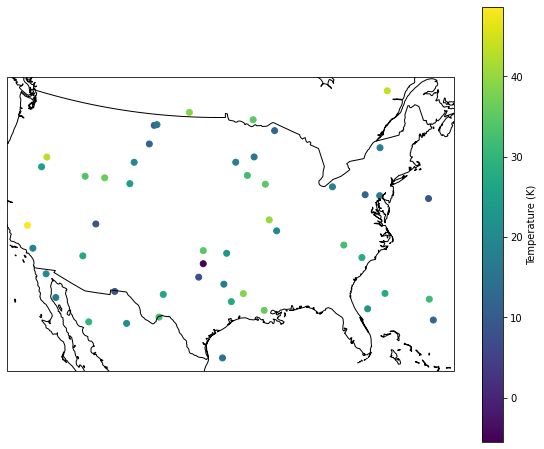

In [3]:
## test showing why I think I can solve this problem fairly easily using a scatter plot!
lon = np.random.rand(50) * 50 - 120
lat = np.random.rand(50) * 25 + 25
temps = np.random.randn(50) * 10 + 25

fig = plt.figure( figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
img = ax.scatter(lon, lat, c=temps, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
fig.colorbar(mappable=img, label="Temperature (K)")

In [4]:
in_situ_path = "/Users/etmu9498/research/data/in-situ"
in_situ_list = make_plots.load_flight_level( in_situ_path)
in_situ_name = in_situ_list[ 32]
goes_path = "/Users/etmu9498/research/data/goes-satellite/0927"
goes_names = goes_gifs.load_goes( goes_path)

crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path)
crl_name = crl_list[ 17]

os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)
os.chdir( goes_path)

os.chdir( in_situ_path)
in_situ_data = pd.read_csv( in_situ_name, header=None)
in_situ_data


# make in situ data more manageable to work by using pandas, then convert to xarray
# don't split up this cell or else this code won't work properly!


# make values stored in 2nd or 3rd row the header ( the ones with variable descriptors, for some reason this varies
# between data sets)


for col_ind in range( len( in_situ_data.columns)):
    # print( col_ind)
    if in_situ_data.iloc[ col_ind][1] == 'TIME':
        in_situ_data.columns = in_situ_data.iloc[ col_ind]
        break

# removing 1203 rows that just repeat the header keys, and 6 rows with empty lat lon
in_situ_data = in_situ_data[ in_situ_data['TIME'] != 'TIME']
in_situ_data = in_situ_data[ ~ pd.isna( in_situ_data['LATref']) ]
# removing 4 columns that are labeled as 'none'
in_situ_data.drop( 'none', inplace=True, axis=1)

# trim out every 10th element for a new, smaller dataset. Easier / faster to work with?
in_situ_data_trim = in_situ_data.iloc[ ::5, :]
# reset indices so they're nice and pretty!
in_situ_data_trim = in_situ_data_trim.reset_index( drop=True)
# in_situ_data_trim

# adding datetime and just time columns to pandas dataframe
in_situ_data_trim['dt'] = pd.to_datetime( in_situ_data_trim['TIME'])
in_situ_data_trim['time'] = [dt_object.time() for dt_object in in_situ_data_trim.dt ]

# convert from pandas to xarray
xr_in_situ =  pd.DataFrame.to_xarray( in_situ_data_trim) 
# remove 'index' from the coordinates tab... not sure about this?
xr_in_situ = xr_in_situ.drop_vars( 'index')

print( len( xr_in_situ.LATref))
print( len( xr_in_situ.LONref))

ws = xr_in_situ["WS.d"].values
ws = [ float( line) for line in ws]
print( np.max( ws))
print( np.min( ws))

in situ data files:
0) 20210527H1_iwg1.txt
1) 20210713H1_iwg1.txt
2) 20210716H1_iwg1.txt
3) 20210811H1_iwg1.txt
4) 20210812H1_iwg1.txt
5) 20210812H2_iwg1.txt
6) 20210813H1_iwg1.txt
7) 20210816H1_iwg1.txt
8) 20210817H1_iwg1.txt
9) 20210818H1_iwg1.txt
10) 20210818I1_iwg1.txt
11) 20210818N1_iwg1.txt
12) 20210819H1_iwg1.txt
13) 20210819N1_iwg1.txt
14) 20210820H1_iwg1.txt
15) 20210821H1_iwg1.txt
16) 20210821H2_iwg1.txt
17) 20210827H1_iwg1.txt
18) 20210828H1_iwg1.txt
19) 20210828I1_iwg1.txt
20) 20210829H1_iwg1.txt
21) 20210829I1_iwg1.txt
22) 20210905H1_iwg1.txt
23) 20210905I1_iwg1.txt
24) 20210906I1_iwg1.txt
25) 20210913H1_iwg1.txt
26) 20210915H1_iwg1.txt
27) 20210917H1_iwg1.txt
28) 20210923H1_iwg1.txt
29) 20210925H1_iwg1.txt
30) 20210925I1_iwg1.txt
31) 20210926H1_iwg1.txt
32) 20210927H1_iwg1.txt
33) 20210929H1_iwg1.txt
34) 20210929H2_iwg1.txt
35) 20210930H1_iwg1.txt
GOES satellite data files:
0) OR_ABI-L2-MCMIPM1-M6_G16_s20212702130281_e20212702130344_c20212702130423.nc
1) OR_ABI-L2-MCMIPM1

Starting to make image 5
Starting to make image 6


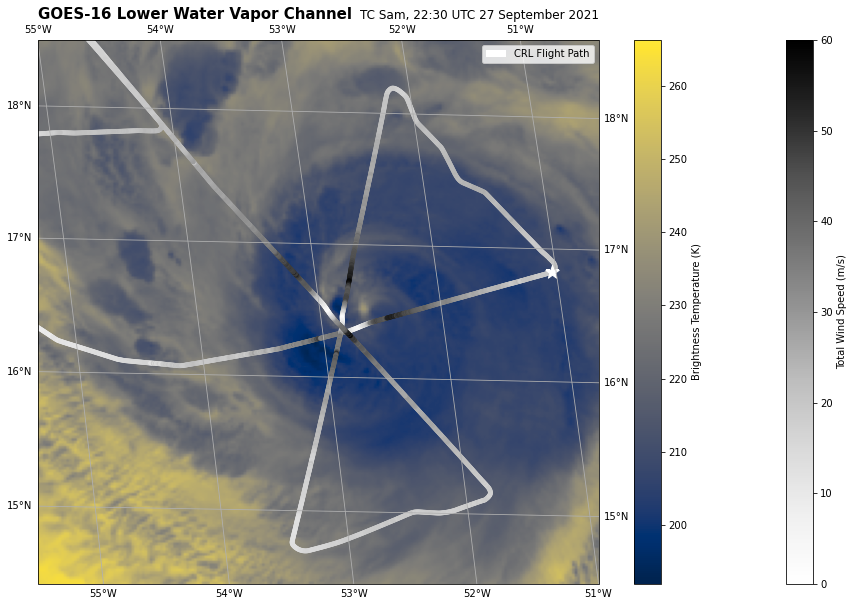

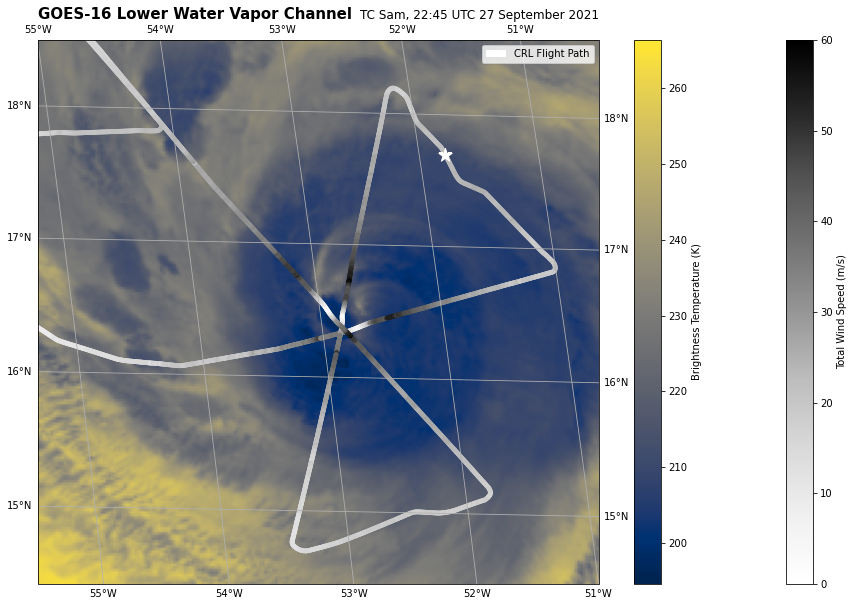

In [8]:
channel_name = "CMI_C10"
channel_full_name = "GOES-16 Lower Water Vapor Channel"
plot_color = 'cividis'
flight_line_color = 'w'
os.chdir( goes_path)

# make images for gif
for goes_ind in range( 4, 6): # len( goes_names)):
    
    # load data for this specific goes_ind
    C = xr.open_dataset( goes_names[ goes_ind])
    t_max = np.max( C[ channel_name].data )
    t_min = np.min( C[ channel_name].data )

    # Scan's start time, converted to datetime object
    # Scan's end time, converted to datetime object
    # File creation time, convert to datetime object
    # The 't' variable is the scan's midpoint time
    scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint = str(C['t'].data)[:-8]
    scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')
    # access wv data!
    wv_upper = C[ channel_name].data
    print("Starting to make image " + str( goes_ind + 1))

    
    
    # make figure: setup
    fig = plt.figure(figsize=(16, 10))
    dat = C.metpy.parse_cf(channel_name)
    x = dat.x
    y = dat.y
    # defining projection for goes data, it's a geostationary projection!
    geos = dat.metpy.cartopy_crs


    ax = fig.add_subplot(1, 1, 1, projection=geos)
    # legend and title
    shape = mpatches.Rectangle((0, 0), 1, 1, facecolor=flight_line_color)
    ax.legend([ shape], ['CRL Flight Path'])
    plt.title( channel_full_name, fontweight='bold', fontsize=15, loc='left')
    plt.title('TC Sam, {}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
              loc='right')
    ax.gridlines(draw_labels=True)

    # plot goes data
    img = ax.imshow( wv_upper, origin='upper',
              cmap= plot_color,
              extent=(x.min(), x.max(), y.min(), y.max()),
              transform=geos, vmin=t_min, vmax=t_max )

    # defining projection for points and line
    center_lon = C.geospatial_lat_lon_extent.geospatial_lon_center
    proj = ccrs.PlateCarree()
    # ccrs.Mercator()
    # ccrs.PlateCarree()
    # ccrs.Geostationary(central_longitude=center_lon, globe=ccrs.Globe(semimajor_axis=6378137.0,semiminor_axis=6356752.3))
    # ccrs.Miller()
    # ccrs.Mercator()

    
    # plot flight path line            
    lon = xr_in_situ.LONref
    lon = [ float( value) for value in lon]
    lat = xr_in_situ.LATref
    lat = [ float( value) for value in lat]
    track = sgeom.LineString(zip(lon, lat))
    
    ws = xr_in_situ["WS.d"].values
    ws = [ float( line) for line in ws]

    # ax.add_geometries([track], crs=proj,facecolor='none', edgecolor= 'g', linewidth=1)
    img2 = ax.scatter( lon, lat,c = ws, transform= proj, s=15, marker='o', vmin=0, vmax=60, cmap= 'Greys' )

    
    # plot star showing plane position
    mid_int = ( int( midpoint[11:13]) + int( midpoint[14:16]) / 60 + int(midpoint[17:19] ) / 3600 )
    if mid_int < 10.0:
        mid_int = mid_int + 24.0
    # look at only the decimal places for time ( minutes + seconds)
    for i in range( len( crl_data.time)):
        if ( crl_data.time[i] % 1 <= mid_int % 1 + .01) and ( crl_data.time[i] % 1 >= mid_int % 1 -.01) and (np.rint( crl_data.time[i] ) == np.rint( mid_int)):
            # make star
            long = crl_data.Lon[i].values
            latit = crl_data.Lat[i].values
            ax.scatter( long, latit, s=200, c= flight_line_color, marker='*', transform=proj ) # marker = 's'
            break
    
    
    ax.set_extent([-55, -51, 14.5, 18.5], crs=ccrs.PlateCarree())
    # ax.set_extent([-56.5, -48, 12, 20], crs=ccrs.PlateCarree())

    fig.colorbar(mappable=img2, label="Total Wind Speed (m/s)")
    fig.colorbar(mappable=img, label="Brightness Temperature (K)")




Starting to make image 5
Starting to make image 6


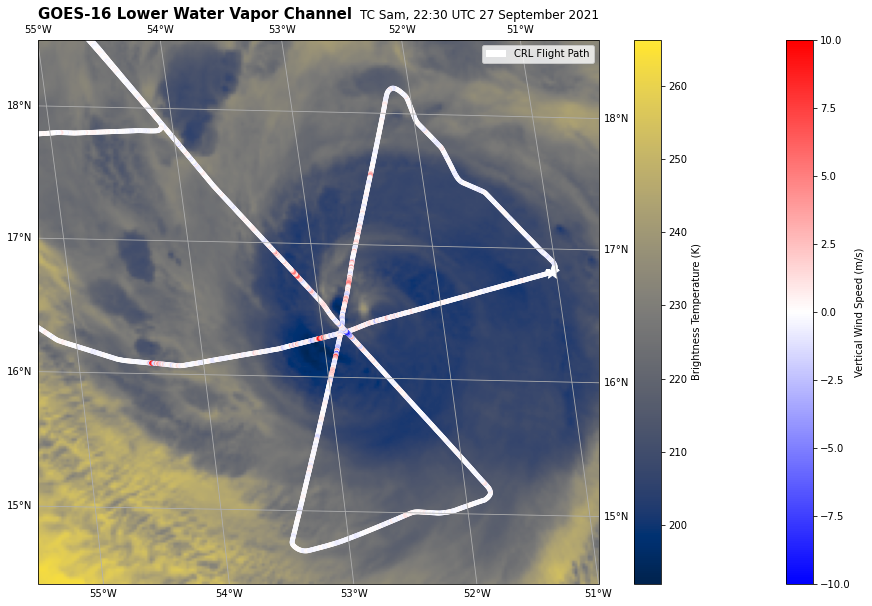

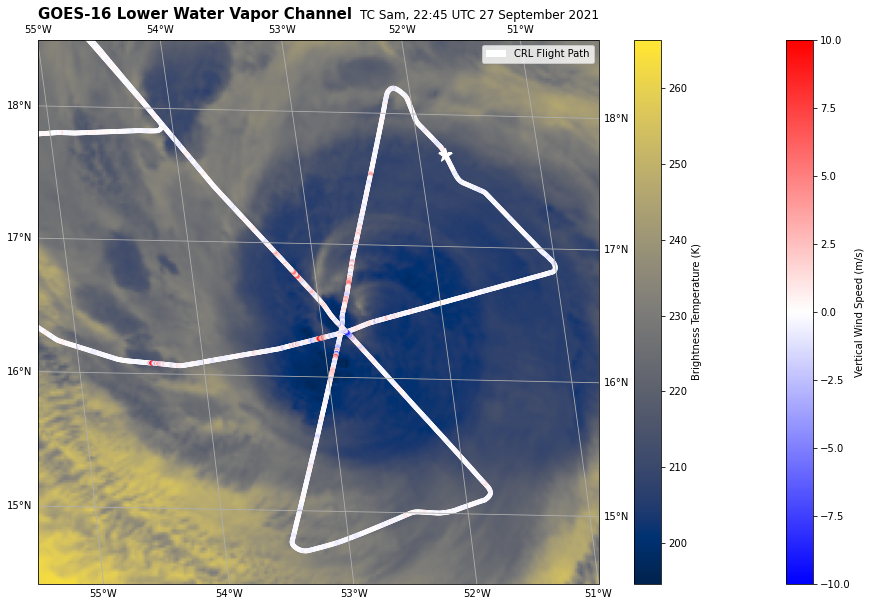

In [9]:
# same as above but for vertical velocity

channel_name = "CMI_C10"
channel_full_name = "GOES-16 Lower Water Vapor Channel"
plot_color = 'cividis'
flight_line_color = 'w'
os.chdir( goes_path)

# make images for gif
for goes_ind in range( 4, 6): # len( goes_names)):
    
    # load data for this specific goes_ind
    C = xr.open_dataset( goes_names[ goes_ind])
    t_max = np.max( C[ channel_name].data )
    t_min = np.min( C[ channel_name].data )

    # Scan's start time, converted to datetime object
    # Scan's end time, converted to datetime object
    # File creation time, convert to datetime object
    # The 't' variable is the scan's midpoint time
    scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint = str(C['t'].data)[:-8]
    scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')
    # access wv data!
    wv_upper = C[ channel_name].data
    print("Starting to make image " + str( goes_ind + 1))

    
    
    # make figure: setup
    fig = plt.figure(figsize=(16, 10))
    dat = C.metpy.parse_cf(channel_name)
    x = dat.x
    y = dat.y
    # defining projection for goes data, it's a geostationary projection!
    geos = dat.metpy.cartopy_crs


    ax = fig.add_subplot(1, 1, 1, projection=geos)
    # legend and title
    shape = mpatches.Rectangle((0, 0), 1, 1, facecolor=flight_line_color)
    ax.legend([ shape], ['CRL Flight Path'])
    plt.title( channel_full_name, fontweight='bold', fontsize=15, loc='left')
    plt.title('TC Sam, {}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
              loc='right')
    ax.gridlines(draw_labels=True)

    # plot goes data
    img = ax.imshow( wv_upper, origin='upper',
              cmap= plot_color,
              extent=(x.min(), x.max(), y.min(), y.max()),
              transform=geos, vmin=t_min, vmax=t_max )

    # defining projection for points and line
    center_lon = C.geospatial_lat_lon_extent.geospatial_lon_center
    proj = ccrs.PlateCarree()
    # ccrs.Mercator()
    # ccrs.PlateCarree()
    # ccrs.Geostationary(central_longitude=center_lon, globe=ccrs.Globe(semimajor_axis=6378137.0,semiminor_axis=6356752.3))
    # ccrs.Miller()
    # ccrs.Mercator()

    
    # plot flight path line            
    lon = xr_in_situ.LONref
    lon = [ float( value) for value in lon]
    lat = xr_in_situ.LATref
    lat = [ float( value) for value in lat]
    track = sgeom.LineString(zip(lon, lat))
    
    ws = xr_in_situ["UWZ.d"].values
    ws = [ float( line) for line in ws]

    # ax.add_geometries([track], crs=proj,facecolor='none', edgecolor= 'g', linewidth=1)
    img2 = ax.scatter( lon, lat,c = ws, transform= proj, s=15, marker='o', vmin=-10, vmax=10, cmap= 'bwr' )

    
    # plot star showing plane position
    mid_int = ( int( midpoint[11:13]) + int( midpoint[14:16]) / 60 + int(midpoint[17:19] ) / 3600 )
    if mid_int < 10.0:
        mid_int = mid_int + 24.0
    # look at only the decimal places for time ( minutes + seconds)
    for i in range( len( crl_data.time)):
        if ( crl_data.time[i] % 1 <= mid_int % 1 + .01) and ( crl_data.time[i] % 1 >= mid_int % 1 -.01) and (np.rint( crl_data.time[i] ) == np.rint( mid_int)):
            # make star
            long = crl_data.Lon[i].values
            latit = crl_data.Lat[i].values
            ax.scatter( long, latit, s=200, c= flight_line_color, marker='*', transform=proj ) # marker = 's'
            break
    
    
    ax.set_extent([-55, -51, 14.5, 18.5], crs=ccrs.PlateCarree())
    # ax.set_extent([-56.5, -48, 12, 20], crs=ccrs.PlateCarree())

    fig.colorbar(mappable=img2, label="Vertical Wind Speed (m/s)")
    fig.colorbar(mappable=img, label="Brightness Temperature (K)")


